## FRAUD AUDIT PREDICTION

**Requirements**
- data: 'audit_risk_data.csv'
- Libraries: pandas, numpy, sklearn, lightgbm, optuna
- Visaualization libraries : matplotlib.pyplot, seaborn

In [195]:
# importing libraries in python

import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
import lightgbm as lgb
from sklearn import metrics
import optuna #hyperparameter tuning

pd.set_option('max_columns', None)
import warnings
warnings.filterwarnings(action='ignore')

## DATA ANALYSIS

In [196]:
# Loading the dataset
df = pd.read_csv('audit_risk_data.csv')

In [198]:
# Printing first 5 rows of the data
df.head()

,Sector_score,LOCATION_ID,PARA_A,PARA_B,numbers,Money_Value,District_Loss,History,Score,Risk
0,3.89,23,4.18,2.50,5.0,3.38,2,0,2.4,1
1,3.89,6,0.00,4.83,5.0,0.94,2,0,2.0,0
2,3.89,6,0.51,0.23,5.0,0.00,2,0,2.0,0
3,3.89,6,0.00,10.80,6.0,11.75,2,0,4.4,1
4,3.89,6,0.00,0.08,5.0,0.00,2,0,2.0,0


In [199]:
# Number of records(rows) and columns
df.shape

(776, 10)

In [200]:
# Getting the informations about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sector_score   776 non-null    float64
 1   LOCATION_ID    776 non-null    object 
 2   PARA_A         776 non-null    float64
 3   PARA_B         776 non-null    float64
 4   numbers        776 non-null    float64
 5   Money_Value    775 non-null    float64
 6   District_Loss  776 non-null    int64  
 7   History        776 non-null    int64  
 8   Score          776 non-null    float64
 9   Risk           776 non-null    int64  
dtypes: float64(6), int64(3), object(1)
memory usage: 60.8+ KB


<AxesSubplot:xlabel='Risk', ylabel='count'>

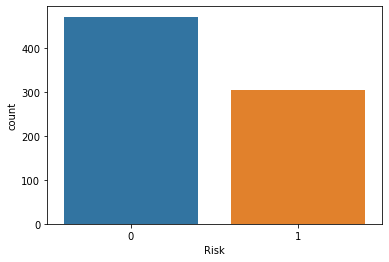

In [201]:
# check if the data os balanced or imbalanced
sns.countplot(df['Risk'], label = "Count")

In [202]:
# check if the data os balanced or imbalanced
df_risk1 = df[df['Risk']==1].value_counts().sum()
df_risk0 = df[df['Risk']==0].value_counts().sum()
perc_risk1 = df_risk1/(df_risk1+df_risk0)
perc_risk0 = df_risk0/(df_risk1+df_risk0)
print('{:.2f}%'.format(perc_risk1*100), 'of the dataset is considered Risk = 1' )
print('{:.2f}%'.format(perc_risk0*100), 'of the dataset is considered Risk = 0' )

39.35% of the dataset is considered Risk = 1
60.65% of the dataset is considered Risk = 0


**** Understanding dataset:
1. Our dataset has 10 columns which includes 9 features and one label/target ('Risk')
2. Number of Instances/rows/records : 776
3. As we can see almost 40% of the data is considered Risk = 1 and 60% is considered Risk = 0. We can say that our classes are highly imbalanced.

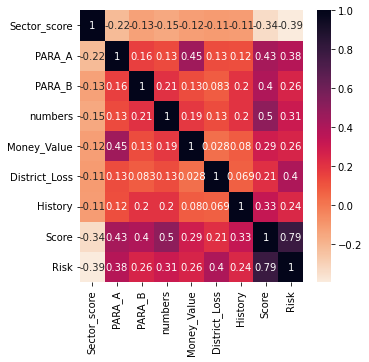

In [203]:
# Get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(5,5))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="rocket_r")

*** Correlation between the features

- 'PARA_A' and 'Money_Value' features are 45% correlated/dependent to each other
- 'Score' and 'Risk' features are 79% correlated. As we know 'Score' feature determines whether to label a company as "fraud"      or "not fraud.", that is why 'Risk' feature and 'Score' are almost 80% correlated.
- 'numbers' and 'score' features are correlated 50%
- 'History' feature and 'District_Loss' are 69% correlated, which make sense. Because 'History' features  shows the average       historical loss suffered by firm in the last 10 years and 'Disrtrict_Loss' presents historical risk score of a district in     the last 10 years. That is why they are highly correlated.

## DATA PREPROCESSING

In [204]:
# Check if there is any NAN_value in the data
df.isnull().sum()

Sector_score     0
LOCATION_ID      0
PARA_A           0
PARA_B           0
numbers          0
Money_Value      1
District_Loss    0
History          0
Score            0
Risk             0
dtype: int64

- As we can see we have only one nan_value which is in the column 'Money_Value'.
- There are several ways to fill the missing value, we talk about few of them:
1. Deleting the columns with missing data : which is not a good idea because 'Money_Value' is one of the important features that help us to have a better prediction.
2. Deleting the rows with missing data : Due to the fact that we don't have many records I prefer to keep the row.
3. Filling the missing data with a value – Imputation : I've choosed to fill the missing value with mean value of the 'Money_Value' column.


In [205]:
 # Filling the missing values in Money_Value column with mean value
df['Money_Value'].fillna((df['Money_Value'].mean()), inplace=True)

In [206]:
# check if we ahve no more nissing value
df.isnull().sum().sum()

0

In [207]:
# Feature encoding for categorical column
# 'LOCATION_ID' is a categorical feature which we will use LabelEncoder to encodding this feature.
# In label encoding we replace the categorical value with a numeric value between 0 and the number of classes minus 1.
# Advantage of the label Encoding is we don't add more features to the data.

le = LabelEncoder()
le.fit(df['LOCATION_ID'])
le.transform(df['LOCATION_ID'])
df['LOCATION_ID'] = le.transform(df['LOCATION_ID'])

In [208]:
# Checking for outliers in the merged dataframe 
for i in df:
    df_mean, df_std = mean(df[i]), std(df[i])
    cut_off = df_std * 3
    lower, upper = df_mean - cut_off, df_mean + cut_off
    outliers = [x for x in df[i] if x < lower or x > upper]
    print('Identified outliers in ' + i + ': %d' % len(outliers))

Identified outliers in Sector_score: 0
Identified outliers in LOCATION_ID: 0
Identified outliers in PARA_A: 7
Identified outliers in PARA_B: 1
Identified outliers in numbers: 22
Identified outliers in Money_Value: 7
Identified outliers in District_Loss: 0
Identified outliers in History: 15
Identified outliers in Score: 0
Identified outliers in Risk: 0


In [209]:
# Splitting the data into features(x) and label(y)
x=df.drop('Risk',axis='columns')
y=df['Risk']

In [210]:
# Train-test split
x_train,x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=42)

In [211]:
#After splitting the data into test and train we check if our data in balanced or not
print('{:.2f}%'.format(sum(y_train==1)/(sum(y_train==1)+sum(y_train==0))*100), 'of the y_train is considered Risk = 1' )
print('{:.2f}%'.format(sum(y_train==0)/(sum(y_train==1)+sum(y_train==0))*100), 'of the y_train is considered Risk = 0' )
print('{:.2f}%'.format(sum(y_test==1)/(sum(y_test==1)+sum(y_test==0))*100), 'of the y_test is considered Risk = 1' )
print('{:.2f}%'.format(sum(y_test==0)/(sum(y_test==1)+sum(y_test==0))*100), 'of the y_test is considered Risk = 0' )


39.52% of the y_train is considered Risk = 1
60.48% of the y_train is considered Risk = 0
38.46% of the y_test is considered Risk = 1
61.54% of the y_test is considered Risk = 0


In [212]:
# As we can see. our test dataset has the same distribution as the train set. 

In [213]:
# Feature Scaling
# The concept of scaling the data is that The dataset may combine features from different dimensions and scales,
# which may have an impact on how a model is trained. Therefore outcomes from a model that was trained with unscaled 
# data may be biased.
# we've used standardization (StandardScaler) for scaling our data

ssc = StandardScaler()
ssc.fit(x_train)
x_train = pd.DataFrame(ssc.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(ssc.transform(x_test), columns=x_test.columns)

## MODEL TRAINING

* Since our problem is a binary classification we choose these models to train our model then  we evaluate our models and choose the best one.
1. Logistik Regression
2. Random Forest
3. KNN
4. SVM
5. Adaboost
6. LightGBM
7. GradientBoosting

We Evaluate the models based on these performance metrics:

- Accuracy: describes the number of correct predictions over all predictions
- Precision: is a measure of how many of the positive predictions made are correct (true positives)
- Recall: is a measure of how many of the positive cases the classifier correctly predicted, over all the positive cases in the data
- F1_score: is a measure combining both precision and recall.
- note: F1_score ranges from 0 to 1, where 0 is the worst possible score and 1 is a perfect score indicating that the model predicts each observation correctly
- note: Since our data is slightly imbalanced aside accuracy we need to calculate precision, recall and F1_score

**1. Logistik Regression**
- Logistic regression is a supervised classification algorithm. It is used to predict a binary outcome based on a set of independent variables

In [214]:
lgreg = LogisticRegression(random_state = 42)
lgreg.fit(x_train, y_train)

LogisticRegression(random_state=42)

**Cross Validation**

In [215]:
# cross validation on training dataset to see the strength of our model
kfold = model_selection.KFold(n_splits=5)
scoring = 'accuracy'

acc_lgreg = cross_val_score(estimator = lgreg, X = x_train, y = y_train, cv = kfold, scoring=scoring)
print('Mean accuracy of Logisitik Regression model with 5-fold cross validation is',acc_lgreg.mean())

Mean accuracy of Logisitik Regression model with 5-fold cross validation is 0.95


**Model Evaluation**

In [217]:
predict_test = lgreg.predict(x_test)
predict_train = lgreg.predict(x_train)

acc_test = accuracy_score(y_test, predict_test)
acc_train = accuracy_score(y_train, predict_train)

auc_lgreg = roc_auc_score(y_test, predict_test)

precision_test = precision_score(y_test, predict_test)
precision_train = precision_score(y_train, predict_train)

recall_test = recall_score(y_test, predict_test)
recall_train = recall_score(y_train, predict_train)

f1_test = f1_score(y_test, predict_test)
f1_train = f1_score(y_train, predict_train)

results_test = pd.DataFrame([['Logistic Regression',acc_test, acc_lgreg.mean(),precision_test ,recall_test, f1_test, auc]],
               columns = ['Model', 'Accuracy_test','Cross Val Accuracy', 'Precision_test', 'Recall_test', 'F1_Score_test','AUC'])
results_test



,Model,Accuracy_test,Cross Val Accuracy,Precision_test,Recall_test,F1_Score_test,AUC
0,Logistic Regression,0.974359,0.95,0.966667,0.966667,0.966667,0.989583


In [218]:
results_train = pd.DataFrame([['Logistic Regression',acc_train, acc_lgreg.mean(),precision_train ,recall_train, f1_train]],
               columns = ['Model', 'Accuracy_train','Cross Val Accuracy', 'Precision_train', 'Recall_train', 'F1_Score_train'])
results_train

,Model,Accuracy_train,Cross Val Accuracy,Precision_train,Recall_train,F1_Score_train
0,Logistic Regression,0.956452,0.95,0.957983,0.930612,0.944099


**2. Random Forest**
- A Random Forest is a supervised machine learning algorithm in which the calculations of numerous decision trees are combined to produce one final result

In [219]:
rf = RandomForestClassifier(n_estimators = 100,criterion='entropy', random_state = 42)
rf.fit(x_train, y_train)


RandomForestClassifier(criterion='entropy', random_state=42)

**Cross Validation**

In [220]:
acc_rf = cross_val_score(estimator = rf, X = x_train, y = y_train, cv = kfold, scoring=scoring)
print('Mean accuracy of Random Forest model with 5-fold cross validation is',acc_rf.mean())

Mean accuracy of Random Forest model with 5-fold cross validation is 0.9758064516129032


**Model Evaluation**

In [221]:
predict_test_rf = rf.predict(x_test)
predict_train_rf = rf.predict(x_train)

acc_test_rf = accuracy_score(y_test, predict_test_rf)
acc_train_rf = accuracy_score(y_train, predict_train_rf)

auc_rf = roc_auc_score(y_test, predict_test_rf)

precision_test_rf = precision_score(y_test, predict_test_rf)
precision_train_rf = precision_score(y_train, predict_train_rf)

recall_test_rf = recall_score(y_test, predict_test_rf)
recall_train_rf = recall_score(y_train, predict_train_rf)

f1_test_rf = f1_score(y_test, predict_test_rf)
f1_train_rf = f1_score(y_train, predict_train_rf)

model_results = pd.DataFrame([['Random forest',acc_test_rf, acc_rf.mean(),precision_test_rf ,recall_test_rf, f1_test_rf, auc_rf]],
               columns = ['Model', 'Accuracy_test','Cross Val Accuracy', 'Precision_test', 'Recall_test', 'F1_Score_test','AUC'])

results_test = results_test.append(model_results, ignore_index = True)
results_test

,Model,Accuracy_test,Cross Val Accuracy,Precision_test,Recall_test,F1_Score_test,AUC
0,Logistic Regression,0.974359,0.950000,0.966667,0.966667,0.966667,0.989583
1,Random forest,0.980769,0.975806,0.952381,1.000000,0.975610,0.984375


**3. k-nearest neighbors** 
- The k-nearest neighbors (KNN) is a supervised classification machin learning method for estimating the likelihood that a data point will become a member of one group or another based on what group the data points nearest to it belong to.

In [222]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsClassifier()

**Cross Validation**

In [223]:
acc_knn = cross_val_score(estimator = knn, X = x_train, y = y_train, cv = kfold, scoring=scoring)
print('Mean accuracy of KNN model with 5-fold cross validation is',acc_knn.mean())

Mean accuracy of KNN model with 5-fold cross validation is 0.935483870967742


**Model Evaluation**

In [224]:
predict_test_knn = knn.predict(x_test)
predict_train_knn = knn.predict(x_train)

acc_test_knn = accuracy_score(y_test, predict_test_knn)
acc_train_knn = accuracy_score(y_train, predict_train_knn)

auc_knn = roc_auc_score(y_test, predict_test_knn)

precision_test_knn = precision_score(y_test, predict_test_knn)
precision_train_knn = precision_score(y_train, predict_train_knn)

recall_test_knn = recall_score(y_test, predict_test_knn)
recall_train_knn = recall_score(y_train, predict_train_knn)

f1_test_knn = f1_score(y_test, predict_test_knn)
f1_train_knn = f1_score(y_train, predict_train_knn)

model_results = pd.DataFrame([['KNN',acc_test_knn, acc_knn.mean(),precision_test_knn ,recall_test_knn, f1_test_knn, auc_knn]],
               columns = ['Model', 'Accuracy_test','Cross Val Accuracy', 'Precision_test', 'Recall_test', 'F1_Score_test','AUC'])

results_test = results_test.append(model_results, ignore_index = True)
results_test

,Model,Accuracy_test,Cross Val Accuracy,Precision_test,Recall_test,F1_Score_test,AUC
0,Logistic Regression,0.974359,0.950000,0.966667,0.966667,0.966667,0.989583
1,Random forest,0.980769,0.975806,0.952381,1.000000,0.975610,0.984375
2,KNN,0.955128,0.935484,0.964912,0.916667,0.940171,0.947917


**4. Support Vector Machine**
- SVM is a supervised classification machine learning algorithm that aims to find an optimal boundary between the possible outputs.

In [225]:
svm = SVC(kernel='linear') 
svm.fit(x_train, y_train)

SVC(kernel='linear')

**Cross Validation**

In [226]:
acc_svm = cross_val_score(estimator = svm, X = x_train, y = y_train, cv = kfold, scoring=scoring)
print('Mean accuracy of SVM model with 5-fold cross validation is',acc_svm.mean())

Mean accuracy of SVM model with 5-fold cross validation is 0.9612903225806452


**Model Evaluation**

In [227]:
predict_test_svm = svm.predict(x_test)
predict_train_svm = svm.predict(x_train)

acc_test_svm = accuracy_score(y_test, predict_test_svm)
acc_train_svm = accuracy_score(y_train, predict_train_svm)

auc_svm = roc_auc_score(y_test, predict_test_svm)

precision_test_svm = precision_score(y_test, predict_test_svm)
precision_train_svm = precision_score(y_train, predict_train_svm)

recall_test_svm = recall_score(y_test, predict_test_svm)
recall_train_svm = recall_score(y_train, predict_train_svm)

f1_test_svm = f1_score(y_test, predict_test_svm)
f1_train_svm = f1_score(y_train, predict_train_svm)

model_results = pd.DataFrame([['SVM',acc_test_svm, acc_svm.mean(),precision_test_svm ,recall_test_svm, f1_test_svm, auc_svm]],
               columns = ['Model', 'Accuracy_test','Cross Val Accuracy', 'Precision_test', 'Recall_test', 'F1_Score_test','AUC'])

results_test = results_test.append(model_results, ignore_index = True)
results_test

,Model,Accuracy_test,Cross Val Accuracy,Precision_test,Recall_test,F1_Score_test,AUC
0,Logistic Regression,0.974359,0.950000,0.966667,0.966667,0.966667,0.989583
1,Random forest,0.980769,0.975806,0.952381,1.000000,0.975610,0.984375
2,KNN,0.955128,0.935484,0.964912,0.916667,0.940171,0.947917
3,SVM,0.980769,0.961290,0.983051,0.966667,0.974790,0.978125


**5. AdaBoostClassifier**
- Adaptive Boosting is one of ensemble boosting classifier. the concept behid Adaboost is to set the weights of classifiers and training the data sample in each iteration such that it ensures the accurate predictions of unusual observations. 

In [228]:
abc = AdaBoostClassifier(n_estimators = 100)
abc.fit(x_train, y_train)

AdaBoostClassifier(n_estimators=100)

**Cross Validation**

In [229]:
acc_abc = cross_val_score(estimator = abc, X = x_train, y = y_train, cv = kfold, scoring=scoring)
print('Mean accuracy of AdaBoostClassifier model with 5-fold cross validation is',acc_abc.mean())

Mean accuracy of AdaBoostClassifier model with 5-fold cross validation is 0.9741935483870968


**Model Evaluation**

In [230]:
predict_test_abc = abc.predict(x_test)
predict_train_abc = abc.predict(x_train)

acc_test_abc = accuracy_score(y_test, predict_test_abc)
acc_train_abc = accuracy_score(y_train, predict_train_abc)

auc_abc = roc_auc_score(y_test, predict_test_abc)

precision_test_abc = precision_score(y_test, predict_test_abc)
precision_train_abc = precision_score(y_train, predict_train_abc)

recall_test_abc = recall_score(y_test, predict_test_abc)
recall_train_abc = recall_score(y_train, predict_train_abc)

f1_test_abc = f1_score(y_test, predict_test_abc)
f1_train_abc = f1_score(y_train, predict_train_abc)

model_results = pd.DataFrame([['AdaBoost',acc_test_abc, acc_abc.mean(),precision_test_abc ,recall_test_abc, f1_test_abc, auc_abc]],
               columns = ['Model', 'Accuracy_test','Cross Val Accuracy', 'Precision_test', 'Recall_test', 'F1_Score_test','AUC'])

results_test = results_test.append(model_results, ignore_index = True)
results_test

,Model,Accuracy_test,Cross Val Accuracy,Precision_test,Recall_test,F1_Score_test,AUC
0,Logistic Regression,0.974359,0.950000,0.966667,0.966667,0.966667,0.989583
1,Random forest,0.980769,0.975806,0.952381,1.000000,0.975610,0.984375
2,KNN,0.955128,0.935484,0.964912,0.916667,0.940171,0.947917
3,SVM,0.980769,0.961290,0.983051,0.966667,0.974790,0.978125
4,AdaBoost,0.974359,0.974194,0.937500,1.000000,0.967742,0.979167


**6. LightGBM**
- LightGBM is a gradient boosting framework that uses tree based learning algorithm.
- LightGBM grows tree vertically while other tree based learning algorithms grow trees horizontally. It means that LightGBM 
grows tree leaf-wise while other algorithms grow level-wise

In [231]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(x_train, y_train)

LGBMClassifier()

**Cross Validation**

In [232]:
acc_lgbm = cross_val_score(estimator = lgbm, X = x_train, y = y_train, cv = kfold, scoring=scoring)
print('Mean accuracy of LightGBMClassifier model with 5-fold cross validation is',acc_lgbm.mean())

Mean accuracy of LightGBMClassifier model with 5-fold cross validation is 0.9758064516129034


**Model Evaluation**

In [233]:
predict_test_lgbm = lgbm.predict(x_test)
predict_train_lgbm = lgbm.predict(x_train)

acc_test_lgbm = accuracy_score(y_test, predict_test_lgbm)
acc_train_lgbm = accuracy_score(y_train, predict_train_lgbm)

auc_lgbm = roc_auc_score(y_test, predict_test_lgbm)

precision_test_lgbm = precision_score(y_test, predict_test_lgbm)
precision_train_lgbm = precision_score(y_train, predict_train_lgbm)

recall_test_lgbm = recall_score(y_test, predict_test_lgbm)
recall_train_lgbm = recall_score(y_train, predict_train_lgbm)

f1_test_lgbm = f1_score(y_test, predict_test_lgbm)
f1_train_lgbm = f1_score(y_train, predict_train_lgbm)

model_results = pd.DataFrame([['LightGBM',acc_test_lgbm, acc_lgbm.mean(),precision_test_lgbm ,recall_test_lgbm, f1_test_lgbm, auc_lgbm]],
               columns = ['Model', 'Accuracy_test','Cross Val Accuracy', 'Precision_test', 'Recall_test', 'F1_Score_test','AUC'])

results_test = results_test.append(model_results, ignore_index = True)
results_test

,Model,Accuracy_test,Cross Val Accuracy,Precision_test,Recall_test,F1_Score_test,AUC
0,Logistic Regression,0.974359,0.950000,0.966667,0.966667,0.966667,0.989583
1,Random forest,0.980769,0.975806,0.952381,1.000000,0.975610,0.984375
2,KNN,0.955128,0.935484,0.964912,0.916667,0.940171,0.947917
3,SVM,0.980769,0.961290,0.983051,0.966667,0.974790,0.978125
4,AdaBoost,0.974359,0.974194,0.937500,1.000000,0.967742,0.979167
5,LightGBM,0.980769,0.975806,0.952381,1.000000,0.975610,0.984375


**7. GradientBoostingClassifier**
- is a functional gradient algorithm that repeatedly selects a function that leads in the direction of a weak hypothesis or negative gradient so that it can minimize a loss function. Gradient boosting classifier combines several weak learning models to produce a powerful predicting model.

In [234]:
xgb = GradientBoostingClassifier()
xgb.fit(x_train, y_train)

GradientBoostingClassifier()

**Cross Validation**

In [235]:
acc_xgb = cross_val_score(estimator = xgb, X = x_train, y = y_train, cv = kfold, scoring=scoring)
print('Mean accuracy of GradientBoosting model with 5-fold cross validation is',acc_xgb.mean())

Mean accuracy of GradientBoosting model with 5-fold cross validation is 0.9774193548387096


**Model Evaluation**

In [236]:
predict_test_xgb = xgb.predict(x_test)
predict_train_xgb = xgb.predict(x_train)

acc_test_xgb = accuracy_score(y_test, predict_test_xgb)
acc_train_xgb = accuracy_score(y_train, predict_train_xgb)

auc_xgb = roc_auc_score(y_test, predict_test_xgb)

precision_test_xgb= precision_score(y_test, predict_test_xgb)
precision_train_xgb = precision_score(y_train, predict_train_xgb)

recall_test_xgb = recall_score(y_test, predict_test_xgb)
recall_train_xgb = recall_score(y_train, predict_train_xgb)

f1_test_xgb = f1_score(y_test, predict_test_xgb)
f1_train_xgb = f1_score(y_train, predict_train_xgb)

model_results = pd.DataFrame([['GradientBoosting',acc_test_xgb, acc_xgb.mean(),precision_test_xgb ,recall_test_xgb, f1_test_xgb, auc_xgb]],
               columns = ['Model', 'Accuracy_test','Cross Val Accuracy', 'Precision_test', 'Recall_test', 'F1_Score_test','AUC'])

results_test = results_test.append(model_results, ignore_index = True)
results_test

,Model,Accuracy_test,Cross Val Accuracy,Precision_test,Recall_test,F1_Score_test,AUC
0,Logistic Regression,0.974359,0.950000,0.966667,0.966667,0.966667,0.989583
1,Random forest,0.980769,0.975806,0.952381,1.000000,0.975610,0.984375
2,KNN,0.955128,0.935484,0.964912,0.916667,0.940171,0.947917
3,SVM,0.980769,0.961290,0.983051,0.966667,0.974790,0.978125
4,AdaBoost,0.974359,0.974194,0.937500,1.000000,0.967742,0.979167
5,LightGBM,0.980769,0.975806,0.952381,1.000000,0.975610,0.984375
6,GradientBoosting,0.987179,0.977419,0.967742,1.000000,0.983607,0.989583


Result:
1. As we can see from the table all of the models perfoms good but if we wnat to compare them GradientBoosting model has highest accuracy : 0.987179
2. GradientBoosting has also highest cross validation which shoew that how great our model is trained.
3. AUC which is Area Under the ROC Curve for the GradientBoosting is the highest.As we know the higher AUC the better the classifier performs. 

**ROC_CURVE**
- Plot the ROC curve

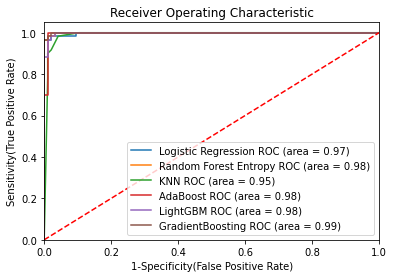

In [237]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(random_state = 42),
},
    {
    'label': 'Random Forest Entropy',
    'model': RandomForestClassifier(n_estimators = 100,criterion='entropy', random_state = 42),
},
    {
    'label': 'KNN',
    'model': KNeighborsClassifier(n_neighbors=5),
},

    {
    'label': 'AdaBoost',
    'model': AdaBoostClassifier(n_estimators = 100),
},
    {
    'label': 'LightGBM',
    'model': lgb.LGBMClassifier(),
},
    {
    'label': 'GradientBoosting',
    'model': GradientBoostingClassifier(),
},
    
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(x_train, y_train) # train the model
    y_pred=model.predict(x_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(x_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [238]:
# As we see the area under GradientBoosting method is higher than the other machine learning methods

## Hyperparameter Tunning

- Hyperprameter tuning is the process of optimizing the performance of a machine learning model by finding the best values for the model’s hyperparameters.
- Hyperparameters are parameters that are not directly learned by the model during training; instead, they are set by the programmer before training begins
- we use Optuna library to do hyperparameter tuning
- we applied hyperparameter tunning on the GradientBoosting model which performs betetr than other models on our data

In [239]:
# Tunning Parameter
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=15)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

- n_estimators : The number of boosting stages to perform
- max_depth : The maximum depth of the individual regression estimators
- learning_rate : Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.

In [240]:
def XGBoost_objective(trial):
    _n_estimators = trial.suggest_categorical("n_estimators", [5,50,150,500])
    _max_depth = trial.suggest_int("max_depth", 1, 19, step=3)
    _learning_rate = trial.suggest_float("learning_rate", 0.1, 0.31, step=0.1)

   
    xgb = GradientBoostingClassifier(
        n_estimators=_n_estimators,
        max_depth=_max_depth,
        learning_rate=_learning_rate,
        random_state=42,
    )
    
    scores = cross_val_score(
        estimator = xgb, X = x_train, y = y_train, cv = kfold, scoring=scoring
    )
    return scores.mean()

In [241]:
XGBoost_params = tune(XGBoost_objective)

[I 2022-11-28 01:35:06,887] A new study created in memory with name: no-name-0095cf5d-d6da-4b12-a4b9-66e08c19cefe
[I 2022-11-28 01:35:10,445] Trial 0 finished with value: 0.9774193548387096 and parameters: {'n_estimators': 500, 'max_depth': 19, 'learning_rate': 0.1}. Best is trial 0 with value: 0.9774193548387096.
[I 2022-11-28 01:35:11,615] Trial 1 finished with value: 0.9774193548387096 and parameters: {'n_estimators': 150, 'max_depth': 13, 'learning_rate': 0.2}. Best is trial 0 with value: 0.9774193548387096.
[I 2022-11-28 01:35:11,692] Trial 2 finished with value: 0.9741935483870968 and parameters: {'n_estimators': 5, 'max_depth': 7, 'learning_rate': 0.2}. Best is trial 0 with value: 0.9774193548387096.
[I 2022-11-28 01:35:11,745] Trial 3 finished with value: 0.9774193548387096 and parameters: {'n_estimators': 5, 'max_depth': 13, 'learning_rate': 0.3}. Best is trial 0 with value: 0.9774193548387096.
[I 2022-11-28 01:35:11,775] Trial 4 finished with value: 0.9193548387096774 and par

Best score: 0.9822580645161292

Optimized parameters: {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1}



In [242]:
# we have achieved teh best accuracy = 0.9806451612903228 by these optimized parameters
# Optimized parameters: {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2}

In [243]:
xgb_tune = GradientBoostingClassifier(n_estimators=50, max_depth=7, learning_rate=0.2, random_state =42)
xgb_tune.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=7, n_estimators=50,
                           random_state=42)

In [244]:
#Cross Validation
acc_xgb_tune = cross_val_score(estimator = xgb_tune, X = x_train, y = y_train, cv = kfold, scoring=scoring)
print('Mean accuracy of GradientBoosting model with 5-fold cross validation is',acc_xgb_tune.mean())

Mean accuracy of GradientBoosting model with 5-fold cross validation is 0.9806451612903228


In [245]:
predict_test_xgb_tune = xgb.predict(x_test)

acc_test_xgb_tune = accuracy_score(y_test, predict_test_xgb_tune)
auc_xgb_tune = roc_auc_score(y_test, predict_test_xgb_tune)
precision_test_xgb_tune= precision_score(y_test, predict_test_xgb_tune)
recall_test_xgb_tune = recall_score(y_test, predict_test_xgb_tune)
f1_test_xgb_tune = f1_score(y_test, predict_test_xgb_tune)

model_results = pd.DataFrame([['Hyperparam_Tunning_GBoost',acc_test_xgb_tune, acc_xgb_tune.mean(),precision_test_xgb_tune ,recall_test_xgb_tune, f1_test_xgb_tune, auc_xgb_tune]],
               columns = ['Model', 'Accuracy_test','Cross Val Accuracy', 'Precision_test', 'Recall_test', 'F1_Score_test','AUC'])

results_test = results_test.append(model_results, ignore_index = True)
results_test

,Model,Accuracy_test,Cross Val Accuracy,Precision_test,Recall_test,F1_Score_test,AUC
0,Logistic Regression,0.974359,0.950000,0.966667,0.966667,0.966667,0.989583
1,Random forest,0.980769,0.975806,0.952381,1.000000,0.975610,0.984375
2,KNN,0.955128,0.935484,0.964912,0.916667,0.940171,0.947917
3,SVM,0.980769,0.961290,0.983051,0.966667,0.974790,0.978125
4,AdaBoost,0.974359,0.974194,0.937500,1.000000,0.967742,0.979167
5,LightGBM,0.980769,0.975806,0.952381,1.000000,0.975610,0.984375
6,GradientBoosting,0.987179,0.977419,0.967742,1.000000,0.983607,0.989583
7,Hyperparam_Tunning_GBoost,0.987179,0.980645,0.967742,1.000000,0.983607,0.989583


**Result**
- As we can see by applying hyperparameter tunning our model the cross_validation_accurace gets higher could train the data better. but we got almost the same result performance metric as the model without applying hyperparameter tunning.
- I only consider 3 hyperparameters, but we can also consider other parameter and in that case maybe we could reach higher performance metrics.